# Dự đoán Mức độ Nghiêm trọng Tai nạn Giao thông
## (Accident Severity Prediction)

**Bài tập lớn môn: Tiền xử lý dữ liệu**

---

### Mục tiêu
Xây dựng mô hình Machine Learning để dự đoán mức độ nghiêm trọng của tai nạn giao thông dựa trên các yếu tố như thời tiết, vị trí, điều kiện đường xá.

### Dataset
- **Nguồn:** [US Accidents (Kaggle)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents)
- **Mô tả:** Dataset chứa thông tin về tai nạn giao thông tại Mỹ từ 2016-2023

### Phương pháp
- **Bài toán:** Binary Classification (Mild vs Severe)
- **Models:** Logistic Regression, Random Forest, XGBoost

---
## 1. Import Libraries và Modules

In [1]:
# Import thư viện chuẩn
import sys
import warnings
warnings.filterwarnings('ignore')

# Thêm đường dẫn src vào sys.path
sys.path.append('..')

# Import các modules tự viết
from src.data_loader import DataLoader
from src.data_preprocessor import DataPreprocessor
from src.feature_engineer import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.visualizer import Visualizer

---
## 2. Load và Khám phá Dữ liệu (Data Exploration)

In [2]:
# Khởi tạo DataLoader với đường dẫn file CSV
DATA_PATH = '../dataset/US_Accidents_March23.csv'
SAMPLE_SIZE = 500000  # Load 500k dòng để tiết kiệm bộ nhớ

loader = DataLoader(DATA_PATH)
df_raw = loader.load_data(nrows=SAMPLE_SIZE)

Đang load dữ liệu từ: ../dataset/US_Accidents_March23.csv
Đã load thành công 500,000 dòng dữ liệu


In [3]:
# Xem thông tin cơ bản về dataset
info = loader.get_basic_info()

print(f"Shape: {info['shape']}")

Shape: (500000, 46)


In [4]:
# Xem một số dòng mẫu
loader.display_sample(5)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
# Xem phân bố target variable (Severity)
loader.get_target_distribution()


=== Phân bố Severity ===
           Count  Percentage
Severity                    
1            388        0.08
2         312159       62.43
3         187173       37.43
4            280        0.06

Tổng số mẫu: 500,000


,Count,Percentage
Severity,,
1,388,0.08
2,312159,62.43
3,187173,37.43
4,280,0.06



=== Phân bố Severity Gốc (4 Classes: 1-4) ===

Tổng số mẫu: 500,000

Chi tiết phân bố:
----------------------------------------
  Severity 1:        388 mẫu (  0.08%)
  Severity 2:    312,159 mẫu ( 62.43%)
  Severity 3:    187,173 mẫu ( 37.43%)
  Severity 4:        280 mẫu (  0.06%)
----------------------------------------

Nhận xét:
  - Class chiếm nhiều nhất: Severity 2 (62.43%)
  - Class chiếm ít nhất: Severity 4 (0.06%)
  - Tỷ lệ imbalance: 1040.5x

Đã lưu: ../outputs\original_severity_distribution.png


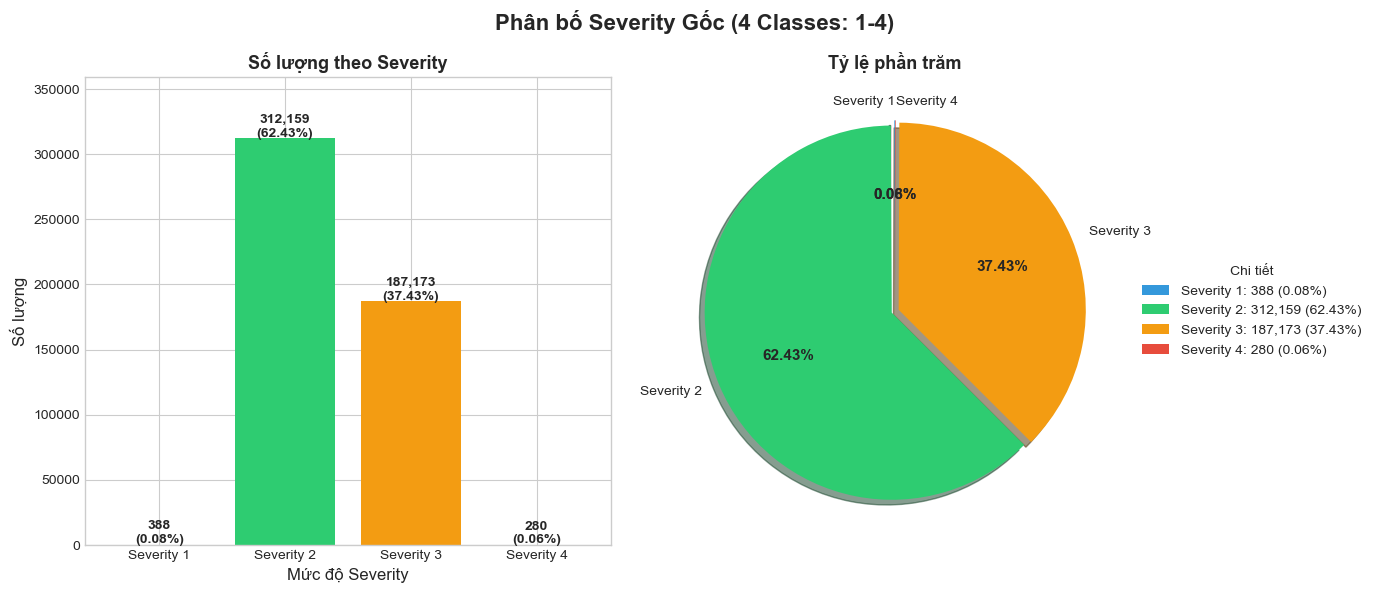

In [6]:
# Visualize phân bố Severity gốc (4 classes)
viz = Visualizer(output_dir='../outputs')
viz.plot_original_severity_distribution(df_raw['Severity'], title='Phân bố Severity Gốc (4 Classes: 1-4)')

In [7]:
# Xem missing values
print("=== Top 15 cột có Missing Values ===")
print(info['missing_values'].head(15))

=== Top 15 cột có Missing Values ===
                    count  percent
End_Lat            500000   100.00
End_Lng            500000   100.00
Precipitation(in)  448054    89.61
Wind_Chill(F)      437641    87.53
Wind_Speed(mph)     89040    17.81
Visibility(mi)      10539     2.11
Weather_Condition   10185     2.04
Humidity(%)          7915     1.58
Temperature(F)       7250     1.45
Pressure(in)         5739     1.15
Wind_Direction       4147     0.83
Weather_Timestamp    4115     0.82
Timezone               58     0.01
Airport_Code           60     0.01
Zipcode                58     0.01



=== Phân tích Missing Values ===

Tổng số dòng: 500,000
Tổng số cột: 46
Số cột có missing: 20

Top 15 cột có missing values cao nhất:
------------------------------------------------------------
Cột                           Số lượng    Tỷ lệ (%)
------------------------------------------------------------
End_Lat                        500,000      100.00%
End_Lng                        500,000      100.00%
Precipitation(in)              448,054       89.61%
Wind_Chill(F)                  437,641       87.53%
Wind_Speed(mph)                 89,040       17.81%
Visibility(mi)                  10,539        2.11%
Weather_Condition               10,185        2.04%
Humidity(%)                      7,915        1.58%
Temperature(F)                   7,250        1.45%
Pressure(in)                     5,739        1.15%
Wind_Direction                   4,147        0.83%
Weather_Timestamp                4,115        0.82%
Airport_Code                        60        0.01%
Timezone       

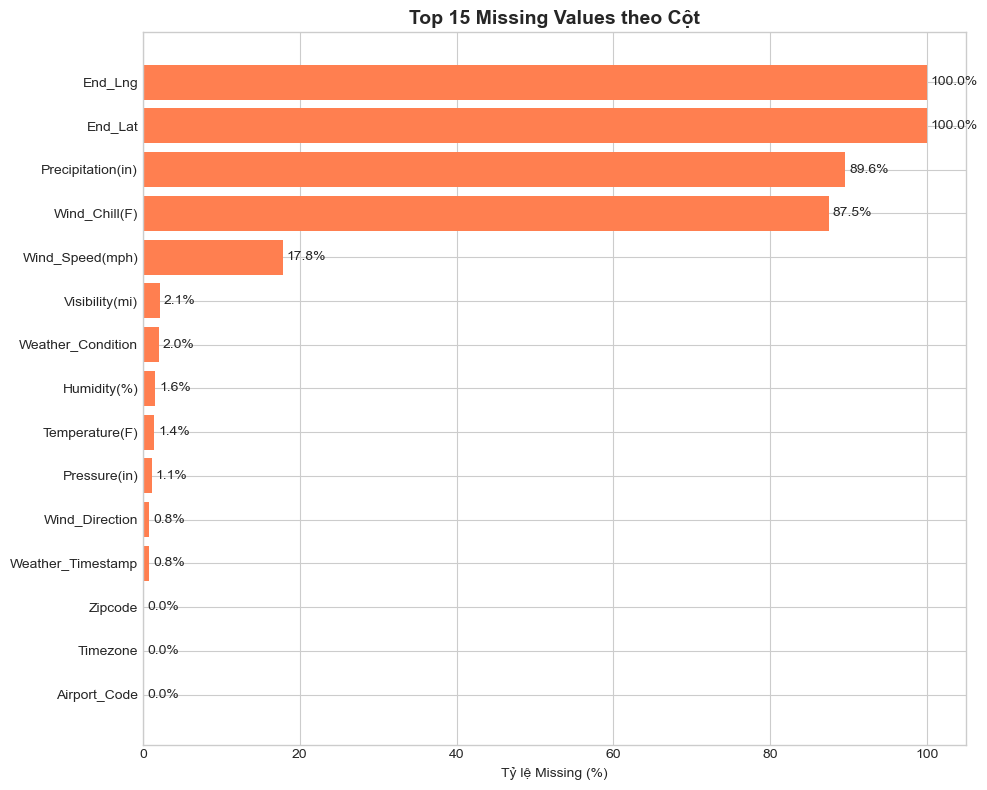

In [8]:
# Visualize missing values
viz.plot_missing_values(df_raw, top_n=15)

### Nhận xét về dữ liệu:
- **Imbalanced Data:** Severity 2 chiếm đa số (~62%), Severity 3 (~37%), Severity 1 và 4 rất ít
- **Missing Values:** Nhiều cột có missing values cao
- **Giải pháp:** Chuyển sang Binary Classification (Mild vs Severe) và xóa cột missing cao

---
## 3. Tiền xử lý Dữ liệu (Data Preprocessing)

In [9]:
# Khởi tạo DataPreprocessor
preprocessor = DataPreprocessor()

# Thực hiện preprocessing pipeline
df_processed = preprocessor.preprocess(df_raw)

BẮT ĐẦU TIỀN XỬ LÝ DỮ LIỆU

Dữ liệu ban đầu: 500,000 dòng, 46 cột

[1/4] Xóa cột không cần thiết...
Xóa 24 cột không cần thiết...
Còn lại 22 cột

[2/4] Xóa dòng trùng lặp...
Đã xóa 476 dòng trùng lặp

[3/4] Điền missing values...
  - Temperature(F): điền 7,246 missing với median = 66.20
  - Humidity(%): điền 7,911 missing với median = 66.00
  - Visibility(mi): điền 10,530 missing với median = 10.00
  - Wind_Speed(mph): điền 88,964 missing với median = 8.10
  - Sunrise_Sunset: điền 22 missing với mode = 'Day'

[4/4] Chuyển đổi target variable...

Phân bố Severity gốc:
Severity
1       388
2    311977
3    186879
4       280
Name: count, dtype: int64

Phân bố Severity sau chuyển đổi (Binary):
  0 (Mild):   312,365 (62.5%)
  1 (Severe): 187,159 (37.5%)

HOÀN THÀNH TIỀN XỬ LÝ
Dữ liệu sau xử lý: 499,524 dòng, 22 cột


In [10]:
# Kiểm tra missing values sau preprocessing
missing_after = preprocessor.get_missing_summary(df_processed)
if len(missing_after) == 0:
    print("✓ Không còn missing values!")
else:
    print("Còn missing values:")
    print(missing_after)

✓ Không còn missing values!



=== Phân bố Severity (Binary: Mild vs Severe) ===

Tổng số mẫu: 499,524

Chi tiết phân bố:
----------------------------------------
  Mild (0):    312,365 mẫu ( 62.53%)
  Severe (1):    187,159 mẫu ( 37.47%)
----------------------------------------

Class ratio (Mild/Severe): 1.67

Đã lưu: ../outputs\target_distribution.png


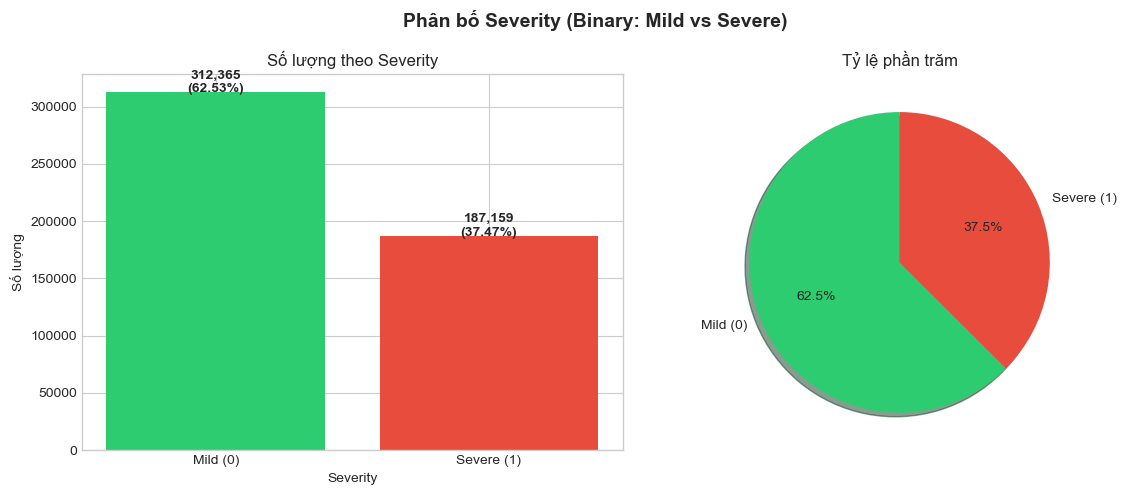

In [11]:
# Visualize phân bố Severity sau chuyển đổi (Binary)
viz.plot_target_distribution(df_processed['Severity'], 
                             title='Phân bố Severity (Binary: Mild vs Severe)')

In [12]:
# Xem các cột còn lại sau preprocessing
print(f"Số cột sau preprocessing: {len(df_processed.columns)}")
print(f"\nDanh sách cột: {df_processed.columns.tolist()}")

Số cột sau preprocessing: 22

Danh sách cột: ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'State', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']


---
## 4. Feature Engineering

In [13]:
# Khởi tạo FeatureEngineer
engineer = FeatureEngineer()

# Thực hiện feature engineering và tách X, y
X, y = engineer.transform(df_processed, fit=True)

BẮT ĐẦU FEATURE ENGINEERING

[1/5] Trích xuất time features...
Đã tạo time features: hour (0-23), day_of_week (0-6)

[2/5] Convert boolean features...
Đã convert 10 boolean features sang 0/1

[3/5] Encode categorical features...
  - Sunrise_Sunset: encoded 2 classes
  - State: encoded 29 classes

[4/5] Scale numerical features...
Đã fit và scale 6 numerical features

[5/5] Chọn features cho model...

Đã chọn 20 features cho model:
  - Numerical: 6
  - Boolean: 10
  - Categorical: 2
  - Time: 2

HOÀN THÀNH FEATURE ENGINEERING
X shape: (499524, 20), y shape: (499524,)


In [14]:
# Xem danh sách features cuối cùng
feature_names = engineer.get_feature_names()
print(f"Số features: {len(feature_names)}")
print(f"\nDanh sách features:")
for i, name in enumerate(feature_names, 1):
    print(f"  {i}. {name}")

Số features: 20

Danh sách features:
  1. Distance(mi)
  2. Temperature(F)
  3. Humidity(%)
  4. Visibility(mi)
  5. Start_Lat
  6. Start_Lng
  7. Traffic_Signal
  8. Junction
  9. Crossing
  10. Stop
  11. Amenity
  12. Bump
  13. Give_Way
  14. No_Exit
  15. Railway
  16. Station
  17. Sunrise_Sunset
  18. State
  19. hour
  20. day_of_week


In [15]:
# Xem sample của X
print("=== Sample Features (X) ===")
X.head()

=== Sample Features (X) ===


,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),Start_Lat,Start_Lng,Traffic_Signal,Junction,Crossing,Stop,Amenity,Bump,Give_Way,No_Exit,Railway,Station,Sunrise_Sunset,State,hour,day_of_week
0,-0.070559,-1.658815,1.246482,0.356410,0.782237,0.740584,0,0,0,0,0,0,0,0,0,0,1,19,5,0
1,-0.070559,-1.599131,1.670636,0.356410,0.794740,0.807733,0,0,0,0,0,0,0,0,0,0,1,19,6,0
2,-0.070559,-1.712530,1.670636,0.356410,0.622856,0.742012,1,0,0,0,0,0,0,0,0,0,1,19,6,0
3,-0.070559,-1.766246,1.482123,-0.115251,0.758907,0.732550,0,0,0,0,0,0,0,0,0,0,1,19,7,0
4,-0.070559,-1.712530,1.152226,-1.530235,0.735065,0.733492,1,0,0,0,0,0,0,0,0,0,0,19,7,0



=== Correlation Matrix ===

Số features: 10

Top 10 cặp features có correlation cao nhất (|r| > 0.3):
------------------------------------------------------------
Feature 1            Feature 2             Correlation
------------------------------------------------------------
Traffic_Signal       Crossing                   0.4785
Temperature(F)       Start_Lat                 -0.4451
Humidity(%)          Visibility(mi)            -0.4072
Temperature(F)       Humidity(%)               -0.3442
------------------------------------------------------------

Đã lưu: ../outputs\correlation_matrix.png


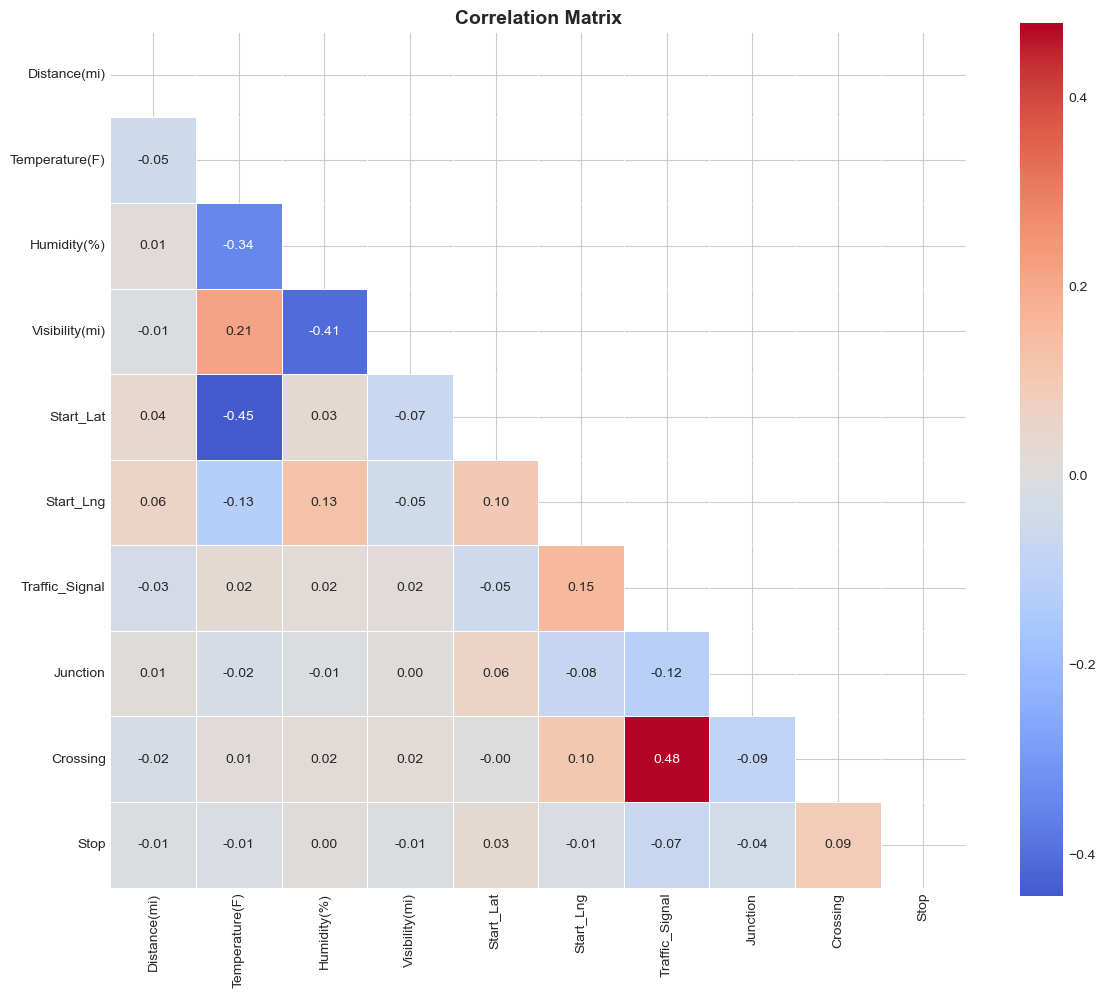

In [16]:
# Visualize correlation matrix
viz.plot_correlation_matrix(X, features=feature_names[:10])  # Top 10 features

---
## 5. Chia dữ liệu Train/Test

In [17]:
# Khởi tạo ModelTrainer
trainer = ModelTrainer()

# Chia dữ liệu với stratified split (80% train, 20% test)
X_train, X_test, y_train, y_test = trainer.split_data(X, y, test_size=0.2)


Chia dữ liệu (stratified split):
  - Training set: 399,619 samples (80%)
  - Test set: 99,905 samples (20%)

Phân bố class trong Training set:
  - Class 0 (Mild): 62.5%
  - Class 1 (Severe): 37.5%


---
## 6. Huấn luyện Models

In [18]:
# Train và evaluate tất cả models
results = trainer.train_and_evaluate_all(X_train, X_test, y_train, y_test)

BẮT ĐẦU TRAINING VÀ EVALUATION
Đã khởi tạo 3 models:
  - Logistic Regression
  - Random Forest
  - XGBoost

Đang train Logistic Regression...
  ✓ Hoàn thành training Logistic Regression

=== Kết quả Logistic Regression ===
  Accuracy:  0.6288
  Precision: 0.5028
  Recall:    0.8237
  F1-Score:  0.6244
  ROC-AUC:   0.7200

Đang train Random Forest...
  ✓ Hoàn thành training Random Forest

=== Kết quả Random Forest ===
  Accuracy:  0.7195
  Precision: 0.5854
  Recall:    0.8616
  F1-Score:  0.6971
  ROC-AUC:   0.8286

Đang train XGBoost...
  ✓ Hoàn thành training XGBoost

=== Kết quả XGBoost ===
  Accuracy:  0.7918
  Precision: 0.6704
  Recall:    0.8742
  F1-Score:  0.7588
  ROC-AUC:   0.8913

★ Model tốt nhất: XGBoost (F1-Score: 0.7588)

HOÀN THÀNH TRAINING VÀ EVALUATION


---
## 7. Đánh giá và So sánh Models

In [19]:
# Bảng so sánh các models
comparison_df = trainer.get_comparison_table()
print("=== Bảng So sánh Models ===")
comparison_df

=== Bảng So sánh Models ===


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,XGBoost,0.791812,0.670382,0.874172,0.758833,0.891261
1,Random Forest,0.719494,0.585378,0.861616,0.697130,0.828648
0,Logistic Regression,0.628757,0.502797,0.823680,0.624427,0.719953



=== So sánh Performance giữa các Models ===

Model                   Accuracy   Precision      Recall    F1-Score     ROC-AUC
--------------------------------------------------------------------------------
XGBoost                   0.7918      0.6704      0.8742      0.7588      0.8913
Random Forest             0.7195      0.5854      0.8616      0.6971      0.8286
Logistic Regression       0.6288      0.5028      0.8237      0.6244      0.7200
--------------------------------------------------------------------------------

★ Model tốt nhất (theo F1-Score): XGBoost (0.7588)

Đã lưu: ../outputs\model_comparison.png


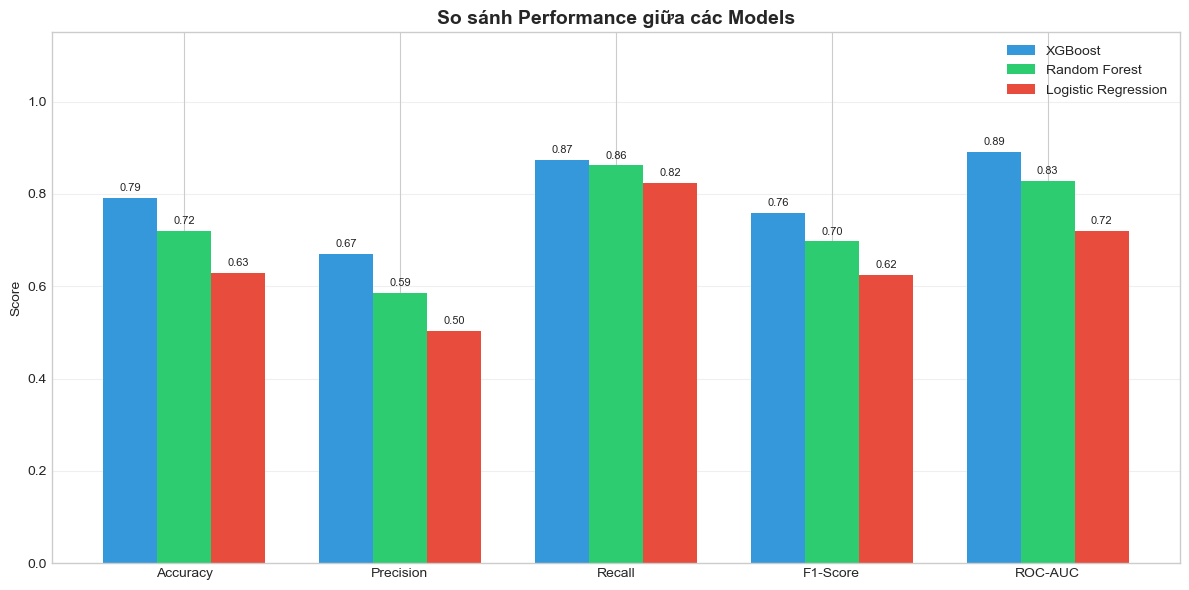

In [20]:
# Visualize so sánh models
viz.plot_model_comparison(comparison_df)


=== ROC Curves - So sánh Models ===

Số mẫu test: 99,905

ROC-AUC Score của các models:
----------------------------------------
  Logistic Regression       AUC = 0.7200
  Random Forest             AUC = 0.8286
  XGBoost                   AUC = 0.8913
----------------------------------------

★ Model có AUC cao nhất: XGBoost (0.8913)

Đã lưu: ../outputs\roc_curves.png


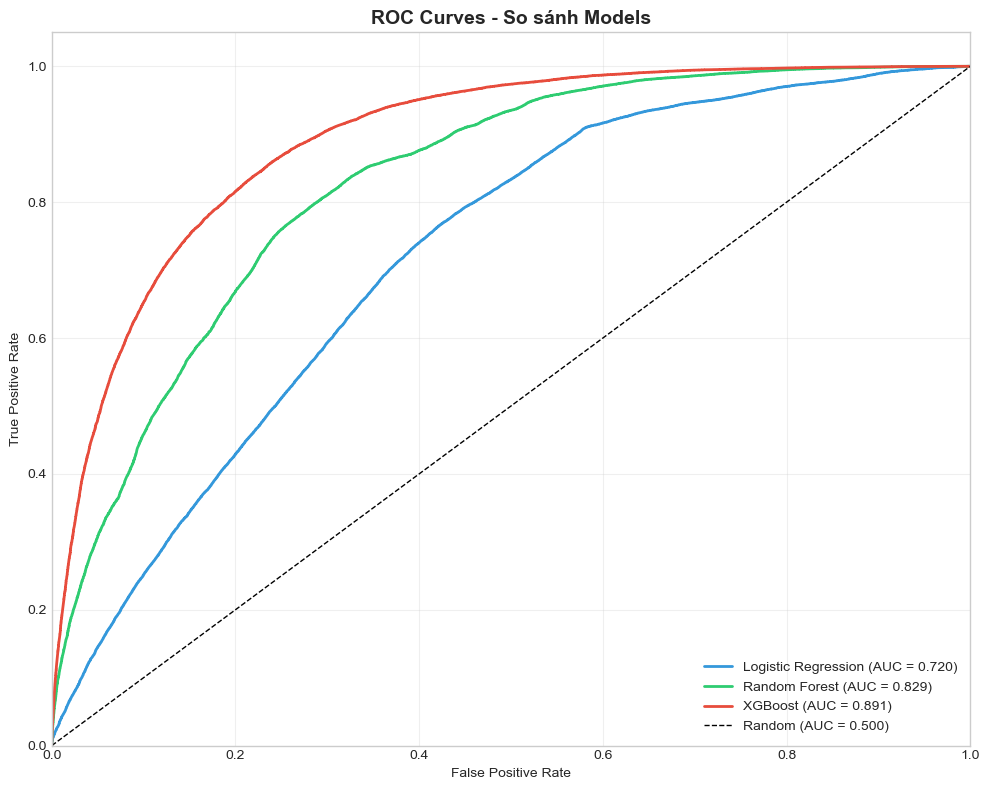

In [21]:
# Vẽ ROC curves
viz.plot_roc_curves(results, y_test)


=== Confusion Matrix: Logistic Regression ===

Tổng số mẫu test: 99,905

Chi tiết Confusion Matrix:
----------------------------------------
  True Negative (TN):    31,984 (32.01%)
  False Positive (FP):   30,489 (30.52%)
  False Negative (FN):    6,600 (6.61%)
  True Positive (TP):    30,832 (30.86%)
----------------------------------------

Metrics từ Confusion Matrix:
  Accuracy:  0.6288
  Precision: 0.5028
  Recall:    0.8237
  F1-Score:  0.6244

Đã lưu: ../outputs\confusion_matrix_logistic_regression.png


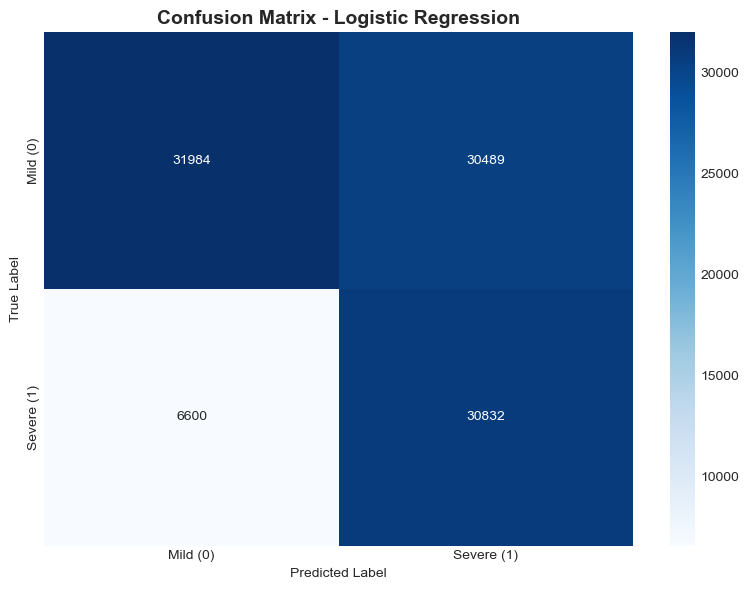


=== Confusion Matrix: Random Forest ===

Tổng số mẫu test: 99,905

Chi tiết Confusion Matrix:
----------------------------------------
  True Negative (TN):    39,629 (39.67%)
  False Positive (FP):   22,844 (22.87%)
  False Negative (FN):    5,180 (5.18%)
  True Positive (TP):    32,252 (32.28%)
----------------------------------------

Metrics từ Confusion Matrix:
  Accuracy:  0.7195
  Precision: 0.5854
  Recall:    0.8616
  F1-Score:  0.6971

Đã lưu: ../outputs\confusion_matrix_random_forest.png


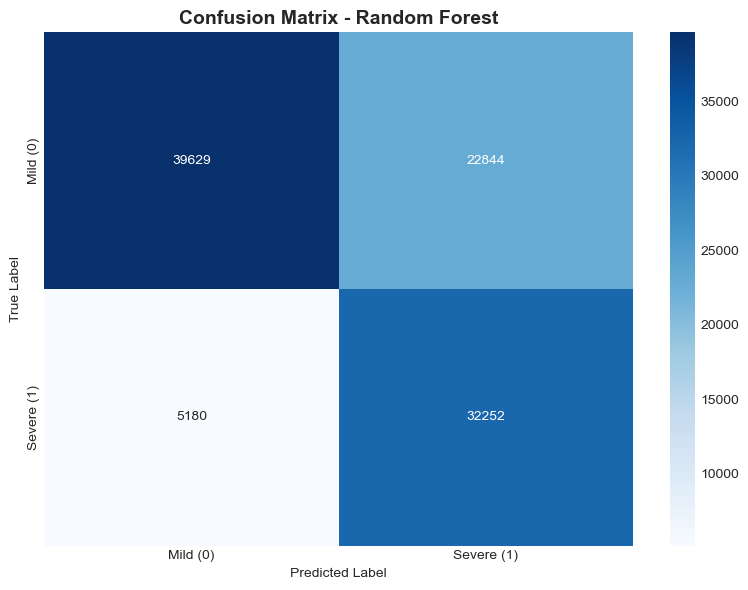


=== Confusion Matrix: XGBoost ===

Tổng số mẫu test: 99,905

Chi tiết Confusion Matrix:
----------------------------------------
  True Negative (TN):    46,384 (46.43%)
  False Positive (FP):   16,089 (16.10%)
  False Negative (FN):    4,710 (4.71%)
  True Positive (TP):    32,722 (32.75%)
----------------------------------------

Metrics từ Confusion Matrix:
  Accuracy:  0.7918
  Precision: 0.6704
  Recall:    0.8742
  F1-Score:  0.7588

Đã lưu: ../outputs\confusion_matrix_xgboost.png


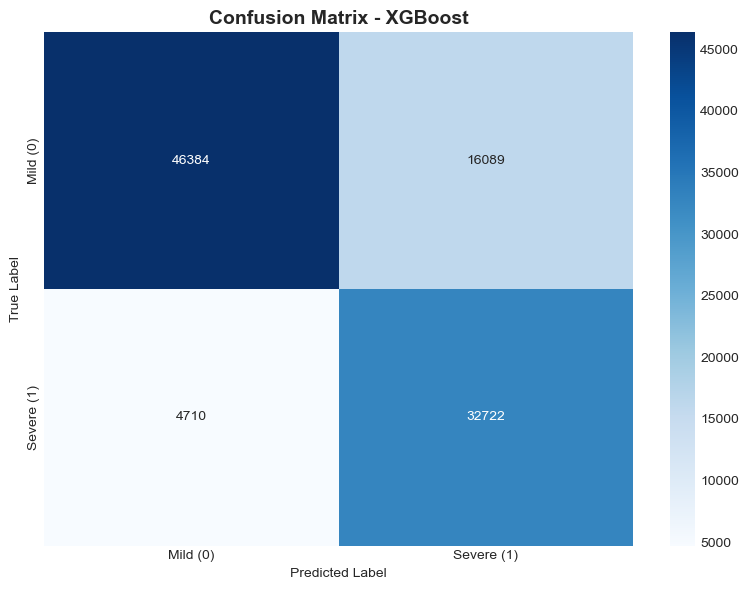

In [22]:
# Confusion Matrix cho từng model
for model_name in results.keys():
    y_pred = results[model_name]['y_pred']
    viz.plot_confusion_matrix(y_test, y_pred, model_name)

In [23]:
# Classification Report chi tiết cho model tốt nhất
best_name, best_model, best_metrics = trainer.get_best_model()
trainer.print_classification_report(best_name, y_test)


=== Classification Report: XGBoost ===
              precision    recall  f1-score   support

    Mild (0)       0.91      0.74      0.82     62473
  Severe (1)       0.67      0.87      0.76     37432

    accuracy                           0.79     99905
   macro avg       0.79      0.81      0.79     99905
weighted avg       0.82      0.79      0.80     99905



---
## 8. Phân tích Feature Importance

In [24]:
# Feature importance từ model tốt nhất
importance_df = trainer.get_feature_importance(best_name, feature_names)

print(f"=== Feature Importance ({best_name}) ===")
importance_df

=== Feature Importance (XGBoost) ===


,feature,importance
6,Traffic_Signal,0.352775
9,Stop,0.155578
8,Crossing,0.105835
17,State,0.064333
0,Distance(mi),0.048847
7,Junction,0.044818
5,Start_Lng,0.035746
10,Amenity,0.034505
4,Start_Lat,0.032658
1,Temperature(F),0.030289



=== Feature Importance (XGBoost) ===

Top 10 features quan trọng nhất:
--------------------------------------------------
Rank   Feature                     Importance
--------------------------------------------------
1      Traffic_Signal                  0.3528
2      Stop                            0.1556
3      Crossing                        0.1058
4      State                           0.0643
5      Distance(mi)                    0.0488
6      Junction                        0.0448
7      Start_Lng                       0.0357
8      Amenity                         0.0345
9      Start_Lat                       0.0327
10     Temperature(F)                  0.0303
--------------------------------------------------

Tổng importance của top 10: 0.9054 (90.5%)

Đã lưu: ../outputs\feature_importance_xgboost.png


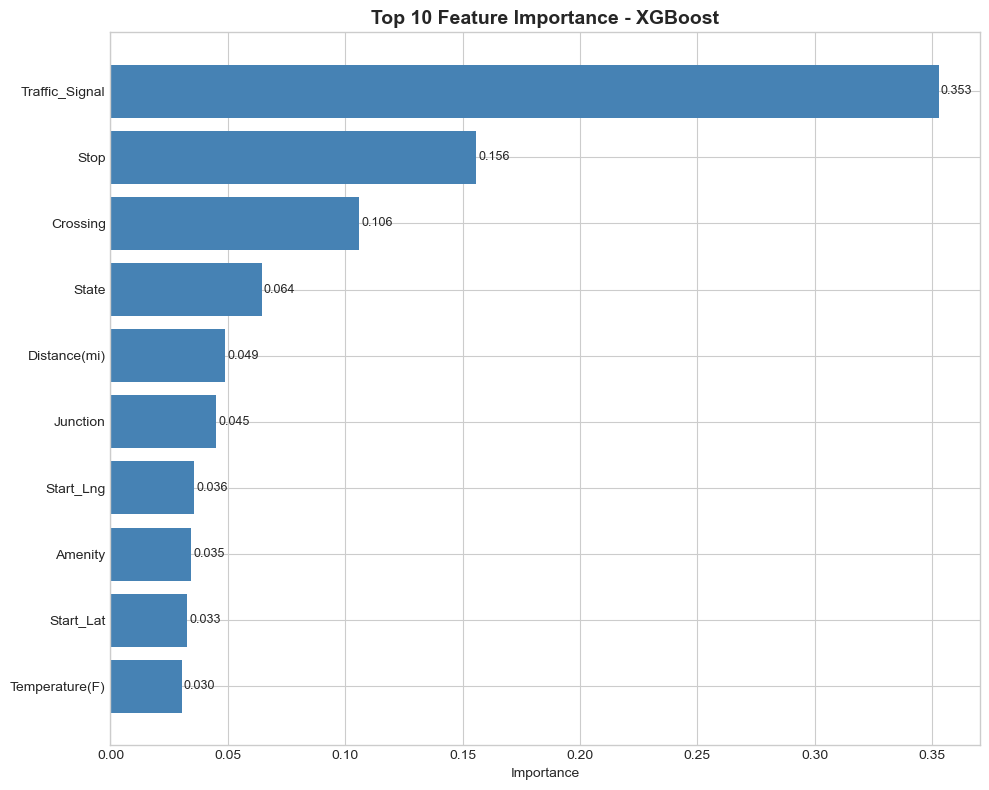

In [25]:
# Visualize feature importance
viz.plot_feature_importance(importance_df, best_name, top_n=10)


=== Feature Importance (Random Forest) ===

Top 10 features quan trọng nhất:
--------------------------------------------------
Rank   Feature                     Importance
--------------------------------------------------
1      Traffic_Signal                  0.2584
2      Start_Lng                       0.1604
3      Crossing                        0.1439
4      Start_Lat                       0.1384
5      State                           0.0932
6      Distance(mi)                    0.0476
7      Stop                            0.0470
8      Junction                        0.0311
9      Temperature(F)                  0.0276
10     Station                         0.0122
--------------------------------------------------

Tổng importance của top 10: 0.9596 (96.0%)

Đã lưu: ../outputs\feature_importance_random_forest.png


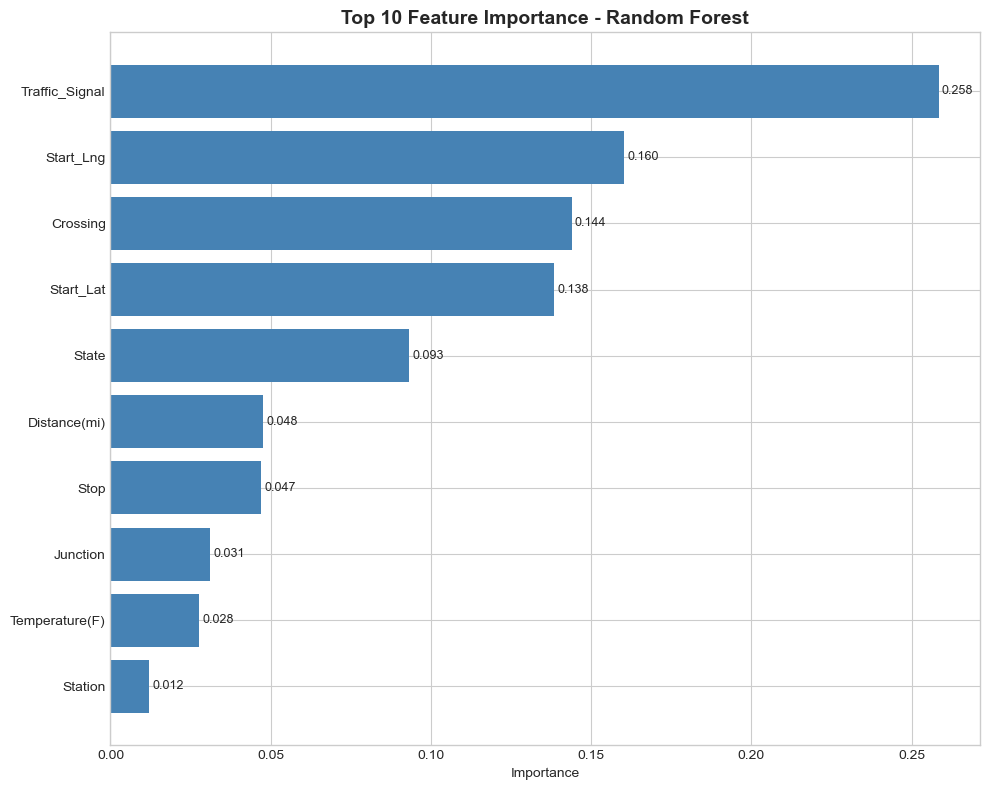

In [26]:
# Feature importance từ Random Forest (nếu không phải best model)
if best_name != 'Random Forest':
    rf_importance = trainer.get_feature_importance('Random Forest', feature_names)
    viz.plot_feature_importance(rf_importance, 'Random Forest', top_n=10)

---
## 9. Lưu Model và Kết luận

In [27]:
# Lưu model tốt nhất
model_path = f'../models/best_model_{best_name.lower().replace(" ", "_")}.joblib'
trainer.save_model(best_name, model_path)

Đã lưu model 'XGBoost' vào: ../models/best_model_xgboost.joblib


### Kết luận

#### Kết quả đạt được:
1. **Preprocessing:** Đã xử lý missing values, chuyển đổi target sang binary classification
2. **Feature Engineering:** Trích xuất time features, encode categorical, scale numerical
3. **Model Training:** So sánh 3 models (Logistic Regression, Random Forest, XGBoost)

#### Model tốt nhất: XGBoost
- Dựa trên F1-Score để đánh giá (do imbalanced data)
- XGBoost hoặc Random Forest thường cho kết quả tốt nhất

#### Features quan trọng nhất:
- Distance, Visibility, Temperature là các yếu tố ảnh hưởng lớn đến severity
- Traffic_Signal, Junction cũng có vai trò quan trọng

#### Hạn chế và hướng phát triển:
- Có thể thử thêm các kỹ thuật xử lý imbalanced data (SMOTE)
- Có thể thêm features từ Weather_Condition
- Có thể tune hyperparameters kỹ hơn